In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import xarray as xr

In [8]:
# initialize constants (SI units)
c = 2.99792458e8  # speed of light
m_e = 9.10938356e-31
q_e = 1.60217662e-19
e_0 = 8.85418782e-12
# calculate frequency properties
lambda_0 = 1800e-9  # central wavelength
omega_0 = 2*np.pi*c/lambda_0

s = 57.5
tau_FWHM = np.sqrt(2)*s*np.sqrt(2**(2/(s+1))-1)/omega_0
tau_0 = s*np.sqrt(np.exp(2/(s+1))-1)/omega_0
delta_omega = 2/tau_0

NA = 0.15
half_angle = np.arcsin(NA)
a = 2/(np.sin(half_angle)*np.tan(half_angle)*2*np.pi/lambda_0)  # set confocal parameter
print(a)
w_00 = 2/(np.tan(half_angle)*2*np.pi/lambda_0)  # set beam waist
print('{0:.3g}'.format(1e6*w_00))
z_R0 = (omega_0*w_00**2)/(2*c)
print(z_R0)

P = 50e12  # FL power
Psi_0 = 0.0*np.pi
phi_2 = 0.0
phi_3 = 0.0
tau_p = 0.5*tau_0

omega = np.linspace(0.1, (omega_0+30*delta_omega), 1000000)
omega_step = omega[1]-omega[0]
time = np.fft.fftshift(np.fft.fftfreq(len(omega), omega_step/(2*np.pi)))

pulse_temp = np.exp(-((omega-omega_0)/delta_omega)**2)
pulse_prep = pulse_temp*np.exp(-1j*((phi_2/2)*(omega-omega_0)**2 + (phi_3/6)*(omega-omega_0)**3))
z_omega = z_R0*tau_p*(omega-omega_0)

2.517668216557665e-05
3.78
2.4891833099572434e-05


(-5.1235306837207543e-14, 1.0247061367441509e-13)

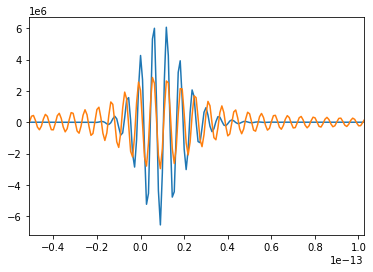

In [9]:
# test on-axis E_z

z = 0.0*a

# April field model
Amp = -1*np.sqrt(8*P/(np.pi*e_0*c))*a*c/(2*omega_0)
Rt = np.sqrt((z - z_omega + 1j*a)**2) + z_omega
Rtomega = np.sqrt((z - z_omega + 1j*a)**2)

pulse_spec = pulse_prep*(2*2*1j*Amp*np.exp(-omega*a/c)/(Rtomega)**2)*(np.sin(omega*Rt/c)/Rtomega-omega*np.cos(omega*Rt/c)/c)
pulse_time = np.fft.fftshift(np.fft.ifft(pulse_spec*np.exp(1j*omega*z/c)))*omega_step/(delta_omega*np.sqrt(np.pi))
field_total_April = np.exp(1j*(Psi_0+np.pi/2))*pulse_time

# standard Gaussian field model
Amp = np.sqrt(8*P/(np.pi*e_0*c))
pulse_spec = pulse_prep*np.exp(1j*(2*np.arctan((z-z_omega)/z_R0)-omega*z/c))/(z_R0*(1+((z-z_omega)/z_R0)**2))
pulse_time = np.fft.fftshift(np.fft.ifft(pulse_spec*np.exp(1j*omega*z/c)))*omega_step/(delta_omega*np.sqrt(np.pi))
field_total = Amp*np.exp(1j*Psi_0)*pulse_time

plt.plot(time, np.real(field_total))
plt.plot(time, np.real(field_total_April))
plt.xlim(-5*tau_0, 10*tau_0)

(-3.074118410232453e-14, 7.172942957209056e-14)

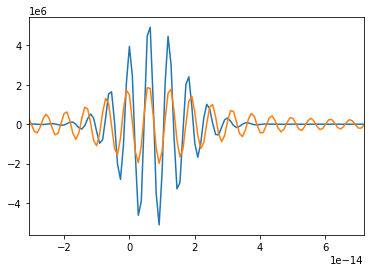

In [10]:
# test off-axis E_z

z = 0.0*a
r = 0.5*w_00

# April field model
Amp = -1*np.sqrt(8*P/(np.pi*e_0*c))*a*c/(2*omega_0)
Rt = np.sqrt(r**2 + (z - z_omega + 1j*a)**2) + z_omega
Rtomega = np.sqrt(r**2 + (z - z_omega + 1j*a)**2)
        
pulse_spec = pulse_prep*(2*1j*Amp*np.exp(-omega*a/c)/(Rtomega**2))*(np.sin(omega*Rt/c)*((2+(omega*r/c)**2)/Rtomega - 3*r**2/Rtomega**3) + 
                                                                    np.cos(omega*Rt/c)*(3*omega*r**2/(Rtomega**2*c)-2*omega/c))
pulse_time = np.fft.fftshift(np.fft.ifft(pulse_spec*np.exp(1j*omega*z/c)))*omega_step/(delta_omega*np.sqrt(np.pi))
field_total_April = np.exp(1j*(Psi_0+np.pi/2))*pulse_time

# standard Gaussian field model
eps = w_00/z_R0
P_corr = 1 + 3*(eps/2)**2 + 9*(eps/2)**4
Amp = np.sqrt(8*P/(P_corr*np.pi*e_0*c)) * (omega_0/(2*c))
phi_G = np.arctan((z-z_omega)/z_R0)
w = w_00*np.sqrt(1+((z-z_omega)/z_R0)**2)
R_inv = (z-z_omega)/((z-z_omega)**2 + z_R0**2)
phi_norm = Psi_0-(omega/c)*(z+(R_inv*r**2)/2)
trans = np.exp(-(r/w)**2)

c_2 = (w_00/w)**2 * np.exp(1j*(phi_norm + 2*phi_G))
c_3 = (w_00/w)**3 * np.exp(1j*(phi_norm + 3*phi_G))
c_4 = (w_00/w)**4 * np.exp(1j*(phi_norm + 4*phi_G))
c_5 = (w_00/w)**5 * np.exp(1j*(phi_norm + 5*phi_G))
c_6 = (w_00/w)**6 * np.exp(1j*(phi_norm + 6*phi_G))
c_7 = (w_00/w)**7 * np.exp(1j*(phi_norm + 7*phi_G))
c_8 = (w_00/w)**8 * np.exp(1j*(phi_norm + 8*phi_G))

rho = r/w_00

pulse_spec = pulse_prep*((c_2 - c_3*rho**2)*eps**2 + 
                         ((1/2)*c_3 + (1/2)*c_4*rho**2 - (5/4)*c_5*rho**4 + (1/4)*c_6*rho**6)*eps**4)
pulse_time = np.fft.fftshift(np.fft.ifft(pulse_spec*np.exp(1j*omega*z/c)))*omega_step/(delta_omega*np.sqrt(np.pi))
field_total = Amp*np.exp(1j*Psi_0)*pulse_time

plt.plot(time, np.real(field_total))
plt.plot(time, np.real(field_total_April))
plt.xlim(-3*tau_0, 7*tau_0)

(-3.074118410232453e-14, 7.172942957209056e-14)

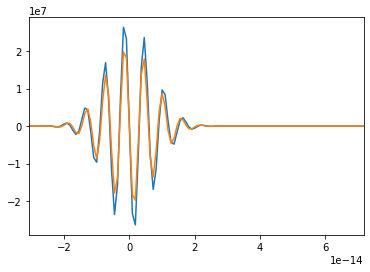

In [306]:
# test off-axis E_r

z = 0.0*a
r = 0.5*w_0

# April field model
Amp = -1*np.sqrt(8*P/(np.pi*e_0*c))*a*c/(2*omega_0)
Rt = np.sqrt(r**2 + (z - z_omega + 1j*a)**2) + z_omega
Rtomega = np.sqrt(r**2 + (z - z_omega + 1j*a)**2)

pulse_spec = pulse_prep*(2*1j*Amp*np.exp(-omega*a/c))*(r*(z - z_omega + 1j*a)/(Rtomega**3))*(np.sin(omega*Rt/c)*(3/(Rtomega**2) - (omega/c)**2) - 
                                                                                           np.cos(omega*Rt/c)*(3*omega/(Rtomega*c)))
pulse_time = np.fft.fftshift(np.fft.ifft(pulse_spec*np.exp(1j*omega*z/c)))*omega_step/(delta_omega*np.sqrt(np.pi))
field_total_April = np.exp(1j*(Psi_0+np.pi/2))*pulse_time

# standard Gaussian field model
eps = w_00/z_R0
P_corr = 1 + 3*(eps/2)**2 + 9*(eps/2)**4
Amp = np.sqrt(8*P/(P_corr*np.pi*e_0*c)) * (omega_0/(2*c))
phi_G = np.arctan((z-z_omega)/z_R0)
w = w_0*np.sqrt(1+((z-z_omega)/z_R0)**2)
R_inv = (z-z_omega)/((z-z_omega)**2 + z_R0**2)
phi_norm = Psi_0-(omega/c)*(z+(R_inv*r**2)/2)
trans = np.exp(-(r/w)**2)

c_2 = (w_0/w)**2 * np.exp(1j*(phi_norm + 2*phi_G))
c_3 = (w_0/w)**3 * np.exp(1j*(phi_norm + 3*phi_G))

rho = r/w_00

pulse_spec = pulse_prep*c_2*rho*eps*np.exp(+1j*np.pi/2)
pulse_time = np.fft.fftshift(np.fft.ifft(pulse_spec*np.exp(1j*omega*z/c)))*omega_step/(delta_omega*np.sqrt(np.pi))
field_total = Amp*np.exp(1j*Psi_0)*pulse_time

plt.plot(time, np.real(field_total))
plt.plot(time, np.real(field_total_April))
plt.xlim(-3*tau_0, 7*tau_0)

(-3.074118410232453e-14, 7.172942957209056e-14)

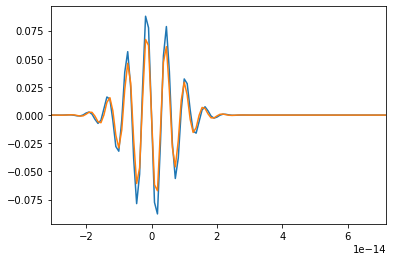

In [307]:
# test off-axis B_t

z = 0.0*a
r = 0.5*w_0

# April field model
Amp = -1*np.sqrt(8*P/(np.pi*e_0*c))*a*c/(2*omega_0)
Rt = np.sqrt(r**2 + (z - z_omega + 1j*a)**2) + z_omega
Rtomega = np.sqrt(r**2 + (z - z_omega + 1j*a)**2)

pulse_spec = pulse_prep*(2*1j*Amp*np.exp(-omega*a/c))*(1j*omega*r/(c*Rtomega)**2)*(np.sin(omega*Rt/c)/Rtomega - 
                                                                                      omega*np.cos(omega*Rt/c)/c)
pulse_time = np.fft.fftshift(np.fft.ifft(pulse_spec*np.exp(1j*omega*z/c)))*omega_step/(delta_omega*np.sqrt(np.pi))
field_total_April = np.exp(1j*(Psi_0+np.pi/2))*pulse_time

# standard Gaussian field model
eps = w_00/z_R0
P_corr = 1 + 3*(eps/2)**2 + 9*(eps/2)**4
Amp = np.sqrt(8*P/(P_corr*np.pi*e_0*c)) * (omega_0/(2*c))
phi_G = np.arctan((z-z_omega)/z_R0)
w = w_0*np.sqrt(1+((z-z_omega)/z_R0)**2)
R_inv = (z-z_omega)/((z-z_omega)**2 + z_R0**2)
phi_norm = Psi_0-(omega/c)*(z+(R_inv*r**2)/2)
trans = np.exp(-(r/w)**2)

c_2 = (w_0/w)**2 * np.exp(1j*(phi_norm + 2*phi_G))
c_3 = (w_0/w)**3 * np.exp(1j*(phi_norm + 3*phi_G))

rho = r/w_0

pulse_spec = pulse_prep*c_2*rho*eps*np.exp(+1j*np.pi/2)/c
pulse_time = np.fft.fftshift(np.fft.ifft(pulse_spec*np.exp(1j*omega*z/c)))*omega_step/(delta_omega*np.sqrt(np.pi))
field_total = Amp*np.exp(1j*Psi_0)*pulse_time

plt.plot(time, np.real(field_total))
plt.plot(time, np.real(field_total_April))
plt.xlim(-3*tau_0, 7*tau_0)